# Chapter7. 신경망 · 딥러닝

## 7-1 뉴런 모델

신경망: 뇌의 신경 회로를 모방한 계산 모델

딥러닝: 심층 신경망 (깊은 층으로 이루어진 신경망)

신경망 모델은 '뉴런 모델' 단위로 구축된다.

### 신경 세포

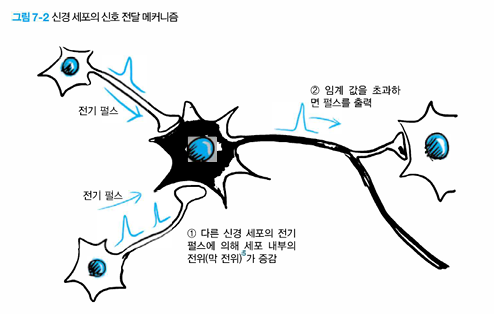

### 뉴런 모델

뉴런 모델: 신경 세포의 움직임을 단순화한 수학적 모델

뉴런에 2개의 입력 $x = (x_0, x_1)$가 들어오는 것을 가정

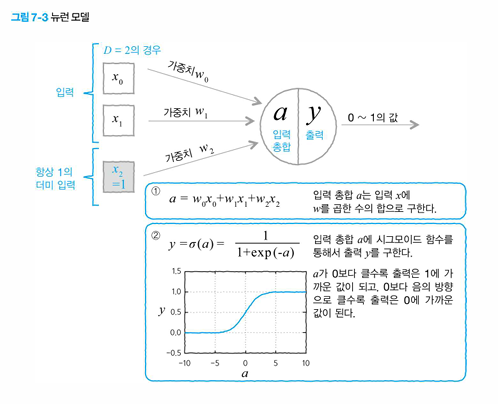

입력 값은 양수와 음수 값을 가질 수 있는 실수

각각의 입력에 대한 시냅스 전달 강도를 $w_0, w_1$로 하고 이것들을 곱하고 더한 후 상수 $w_2$를 더한 것을 입력 총합 $a$로 한다.

신경세포의 출력은 펄스를 보내거나 보내지 않는 2가지 값만 있다고 볼 수 있지만 뉴런 모델에서는 $y$가 $0$부터 $1$까지 연속된 값을 가진다.

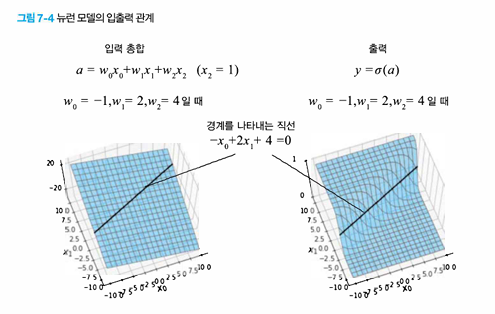

## 7-2 신경망 모델

### 2층 피드 포워드 신경망

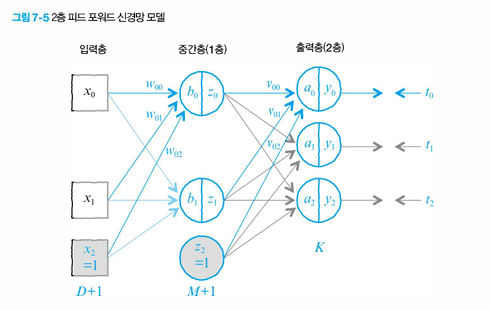

2층의 피드 포워드 신경망

(입력층은 층 계산에서 제외한다.)

2차원의 입력($x_2$는 bias값을 위한 가상 입력이며 실제 입력은 $x_1$과 $x_2$)을 3개의 뉴런으로 출력하기 때문에 2차원에서 주어진 수치를 3개의 카테고리로 분류할 수 있다.

각각의 뉴런의 출력 값이 각각의 카테고리에 속하는 확률을 나타내도록 학습시킨다.

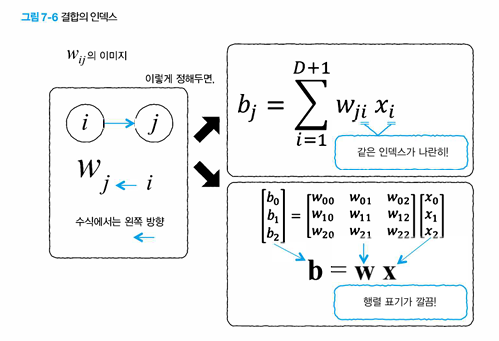

입력 총합을 시그모이드 함수에 적용하여 중간층 뉴런의 출력 $z_j$를 얻는다.

시그모이드 함수가 아니라 다른 함수를 사용하는 것도 가능하다.

출력층에서는 소프트맥스 함수를 적용한다.

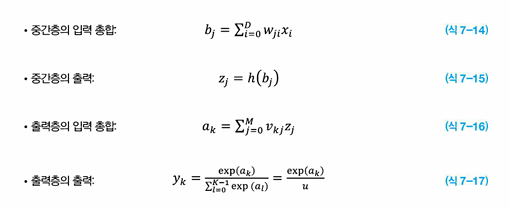

### 2층 피드 포워드 신경망의 구현

데이터 생성 및 저장

In [1]:
import numpy as np

np.random.seed(seed=1)
N = 200
K = 3
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
Mu = np.array([[-0.5, -0.5], [0.5, 1], [1, -0.5]])
Sig = np.array([[0.7, 0.7], [0.8, 0.3], [0.3, 0.8]])
Pi = np.array([0.4, 0.8, 1])
for n in range(N):
  wk = np.random.rand()
  for k in range(K):
    if wk < Pi[k]:
      T[n, k] = 1
      break
  for k in range(2):
    X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n, :] == 1, k]

TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]

np.savez("class_data.npz", X_train=X_train, T_train=T_train, X_test=X_test, T_test=T_test, X_range0=X_range0, X_range1=X_range1)

<ipython-input-1-f6bdcb3aab50>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n, :] == 1, k]


분할한 데이터 그려보기

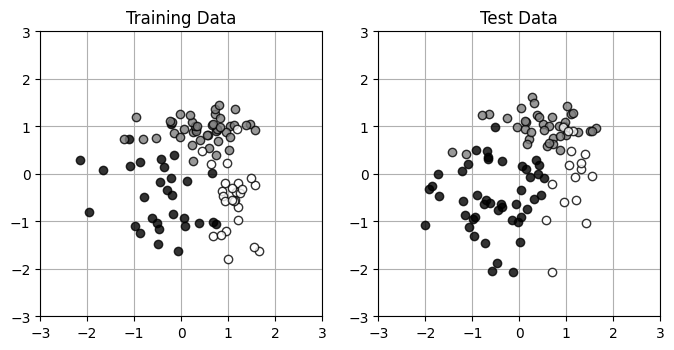

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

def Show_data(x, t):
  wk, n = t.shape
  c = [[0, 0, 0], [0.5, 0.5, 0.5], [1, 1, 1]]
  for i in range(n):
    plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1], linestyle="none", marker="o", markeredgecolor="black", color=c[i], alpha=0.8)
    plt.grid(True)

plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title("Training Data")
plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title("Test Data")
plt.show()

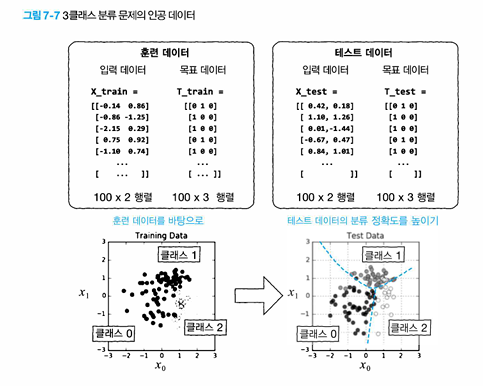

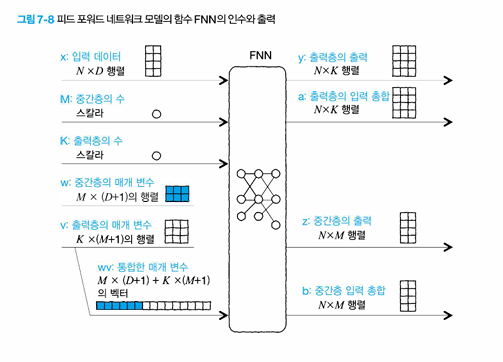

네트워크 함수는 $N$개의 데이터를 한꺼번에 처리할 수 있도록 설계한다.

$x$를 데이터 수 $N * D$차원의 행렬로, $y$를 데이터 수 $N * K$차원의 행렬로 한다.

In [3]:
def Sigmoid(x):
  y = 1 / (1 + np.exp(-x))
  return y

def FNN(wv, M, K, x):
  N, D = x.shape
  w = wv[:M * (D + 1)]
  w = w.reshape(M, (D + 1))
  v = wv[M * (D + 1):]
  v = v.reshape((K, M + 1))
  b = np.zeros((N, M + 1))
  z = np.zeros((N, M + 1))
  a = np.zeros((N, K))
  y = np.zeros((N, K))

  for n in range(N):
    for m in range(M):
      b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1])
      z[n, m] = Sigmoid(b[n, m])
    z[n, M] = 1
    wkz = 0

    for k in range(K):
      a[n, k] = np.dot(v[k, :], z[n, :])
      wkz = wkz + np.exp(a[n, k])
    for k in range(K):
      y[n, k] = np.exp(a[n, k]) / wkz

  return y, a, z, b


WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

### 수치 미분법

2층의 피드 포워드 네트워크에서 3분류 문제 풀기

분류 문제이기 때문에 오차 함수는 평균 교차 엔트로피 오차를 사용

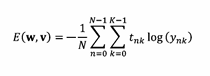

In [4]:
def CE_FNN(wv, M, K, x, t):
  N, D = x.shape
  y, a, z, b = FNN(wv, M, K, x)
  ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
  return ce


WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

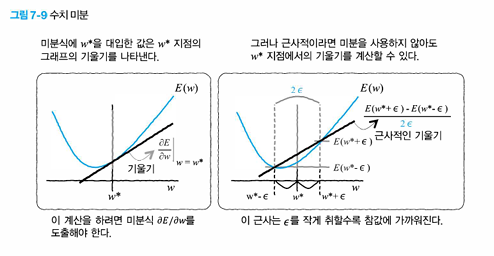

CE_FNN의 수치 미분을 출력하는 함수 dCE_FNN_num 만들기

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


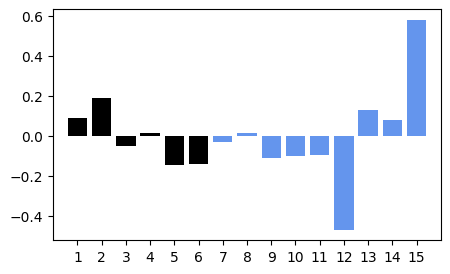

In [5]:
def dCE_FNN_num(wv, M, K, x, t):
  epsilon = 0.001
  dwv = np.zeros_like(wv)
  for iwv in range(len(wv)):
    wv_modified = wv.copy()
    wv_modified[iwv] = wv[iwv] - epsilon
    mse1 = CE_FNN(wv_modified, M, K, x, t)
    wv_modified[iwv] = wv[iwv] + epsilon
    mse2 = CE_FNN(wv_modified, M, K, x, t)
    dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
  return dwv

def Show_WV(wv, M):
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color="black")
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:], align="center", color="cornflowerblue")
  plt.xticks(range(1, N + 1))
  plt.xlim(0, N + 1)


M = 2
K = 3
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)

plt.figure(1, figsize=(5, 3))
Show_WV(dWV, M)
plt.show()

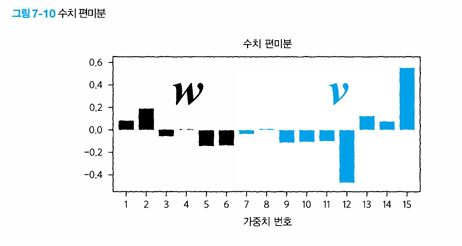

### 수치 미분법에 의한 경사 하강법

분류 문제를 경사 하강법으로 풀기

In [6]:
import time

def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
  wvt = wv_init
  err_train = np.zeros(n)
  err_test = np.zeros(n)
  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001

  for i in range(n):
    wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train)
    err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
    err_test[i] = CE_FNN(wvt, M, K, x_test, t_test)
    wv_hist[i, :] = wvt

  return wvt, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 0.5

WV, WV_hist, Err_train, Err_test = Fit_FNN_num(WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)

calculation_time = time.time() - startTime
print("Calculation time: {0:.3f} sec".format(calculation_time))

Calculation time: 148.445 sec


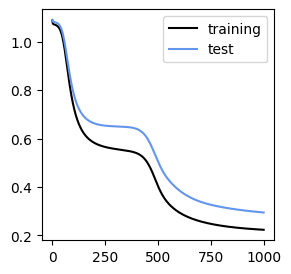

In [7]:
plt.figure(1, figsize=(3, 3))
plt.plot(Err_train, "black", label="training")
plt.plot(Err_test, "cornflowerblue", label="test")
plt.legend()
plt.show()

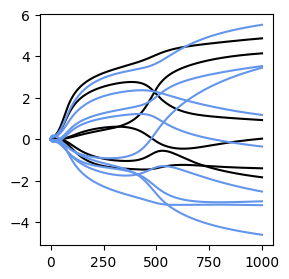

In [8]:
plt.figure(1, figsize=(3, 3))
plt.plot(WV_hist[:, :M * 3], "black")
plt.plot(WV_hist[:, M * 3:], "cornflowerblue")
plt.show()

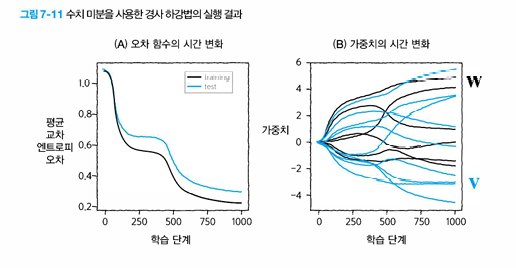

안장점은 방향에 따라 극소값과 극대값을 모두 가지는 지점

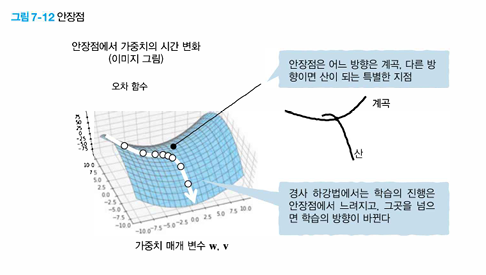

0.9 이상의 출력을 얻을 수 있는 영역을 등고선으로 표시

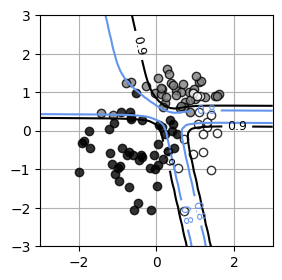

In [9]:
def show_FNN(wv, M, K):
  xn = 60
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1)
  x = np.c_[np.reshape(xx0, xn * xn, "F"), np.reshape(xx1, xn * xn, "F")]
  y, a, z, b = FNN(wv, M, K, x)

  plt.figure(1, figsize=(4, 4))
  for ic in range(K):
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9], colors=["cornflowerblue", "black"])
    cont.clabel(fmt="%.1f", fontsize=9)
  plt.xlim(X_range0)
  plt.ylim(X_range1)

plt.figure(1, figsize=(3, 3))
Show_data(X_test, T_test)
show_FNN(WV, M, K)
plt.show()

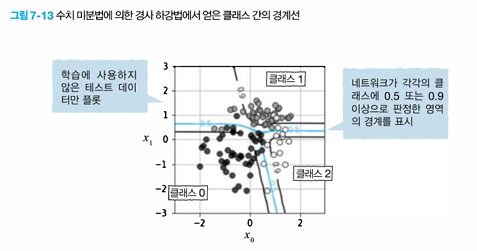

### 오차 역전파법

피드 포워드 신경망에 학습시키는 방법으로 오차 역전파법이 유명하다.

네트워크의 출력에서 발생하는 오차의 정보를 사용하여, 출력층의 가중치 $v_{kj}$에서 중간층에 가중치 $w_{ji}$으로 입력 방향의 반대로 가중치를 갱신해 나간다.

경사 하강법을 피드 포워드 네트워크에 적용하면 오차 역전파법이 자연스럽게 도출된다.

### $\frac{\partial E_n}{\partial v_{kj}}$ 구하기

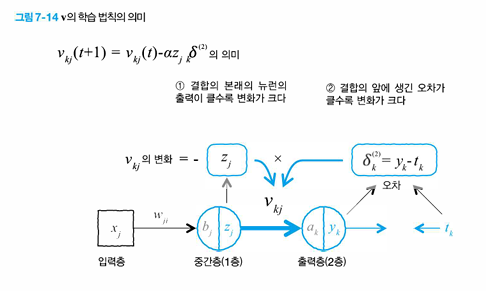

### $\frac{\partial E_n}{\partial w_{ji}}$ 구하기

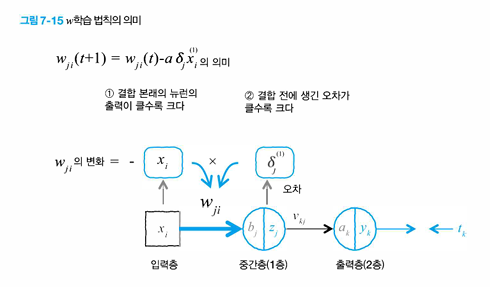

오차의 역전파

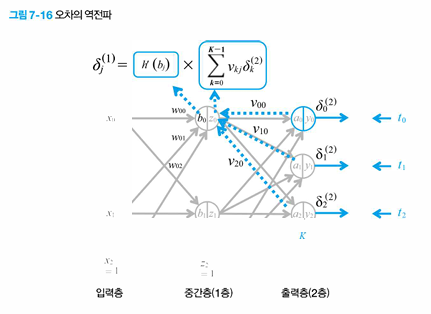

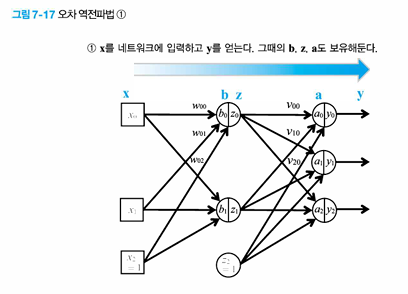

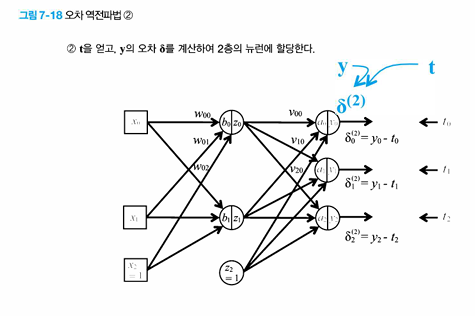

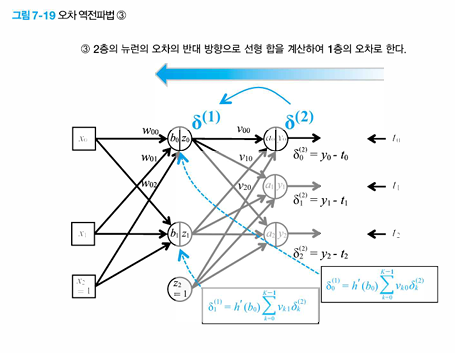

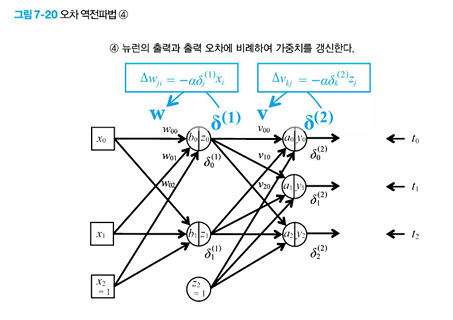

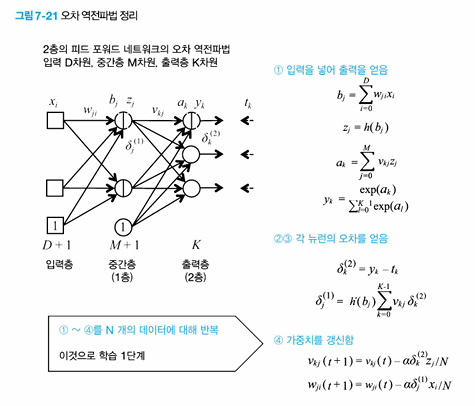

### 오차 역전파법의 구현

In [10]:
def dCE_FNN(wv, M, K, x, t):
  N, D = x.shape

  w = wv[:M * (D + 1)]
  w = w.reshape(M, (D + 1))
  v = wv[M * (D + 1):]
  v = v.reshape(K, (M + 1))

  y, a, z, b = FNN(wv, M, K, x)

  dwv = np.zeros_like(wv)
  dw = np.zeros((M, D + 1))
  dv = np.zeros((K, M + 1))
  delta1 = np.zeros(M)
  delta2 = np.zeros(K)

  for n in range(N):
    for k in range(K):
      delta2[k] = (y[n, k] - t[n, k])

    for j in range(M):
      delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)

    for k in range(K):
      dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N

    for j in range(M):
      dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N

  dwv = np.c_[dw.reshape((1, M * (D + 1))), dv.reshape((1, K * (M + 1)))]
  dwv = dwv.reshape(-1)
  return dwv

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


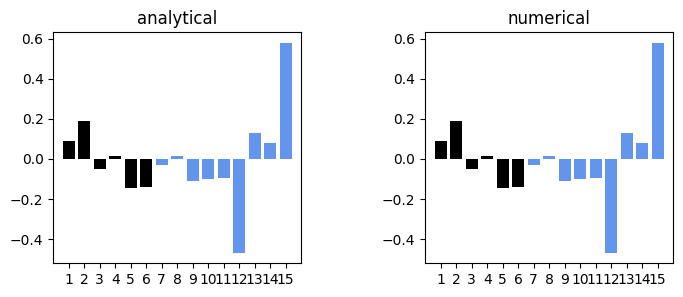

In [11]:
def Show_dWV(wv, M):
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color="black")
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:], align="center", color="cornflowerblue")
  plt.xticks(range(1, N + 1))
  plt.xlim(0, N + 1)

M = 2
K = 3
N = 2
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)

dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)

dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)

plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title("analytical")

plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title("numerical")

plt.show()

해석적 미분값과 수치 미분값 비교하기

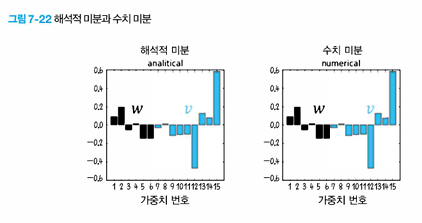

오차 역전파법으로 풀기

In [12]:
import time

def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
  wv = wv_init.copy()
  err_train = np.zeros(n)
  err_test = np.zeros(n)
  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001

  for i in range(n):
    wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train)
    err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
    err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
    wv_hist[i, :] = wv

  return wv, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 1

WV, WV_hist, Err_train, Err_test = Fit_FNN(WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)

calculation_time = time.time() - startTime
print("Calculation time: {0:.3f} sec".format(calculation_time))

Calculation time: 20.639 sec


결과 표시

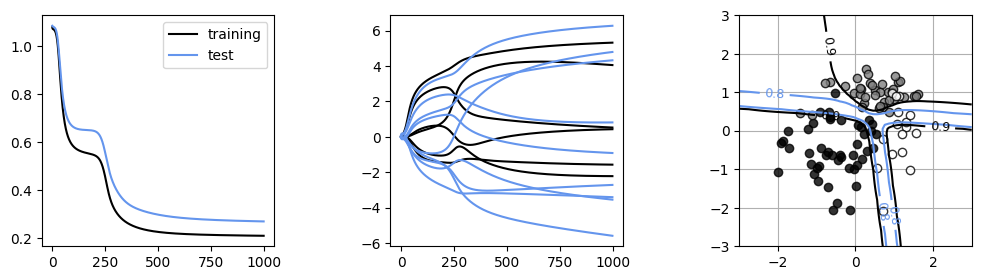

In [13]:
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 3, 1)
plt.plot(Err_train, "black", label="training")
plt.plot(Err_test, "cornflowerblue", label="test")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], "black")
plt.plot(WV_hist[:, M * 3:], "cornflowerblue")
plt.subplot(1, 3, 3)

Show_data(X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()

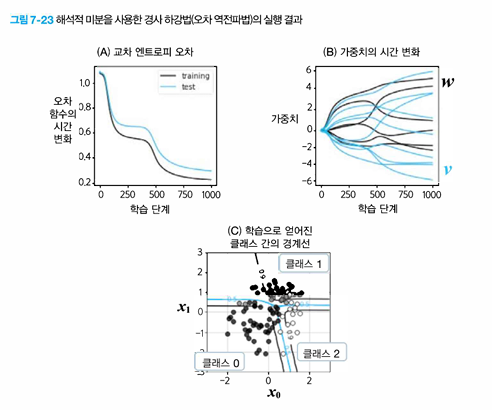

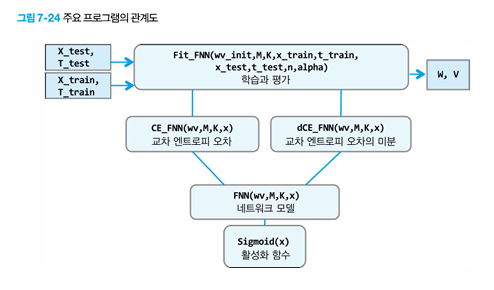

### 학습 후 뉴런의 특성

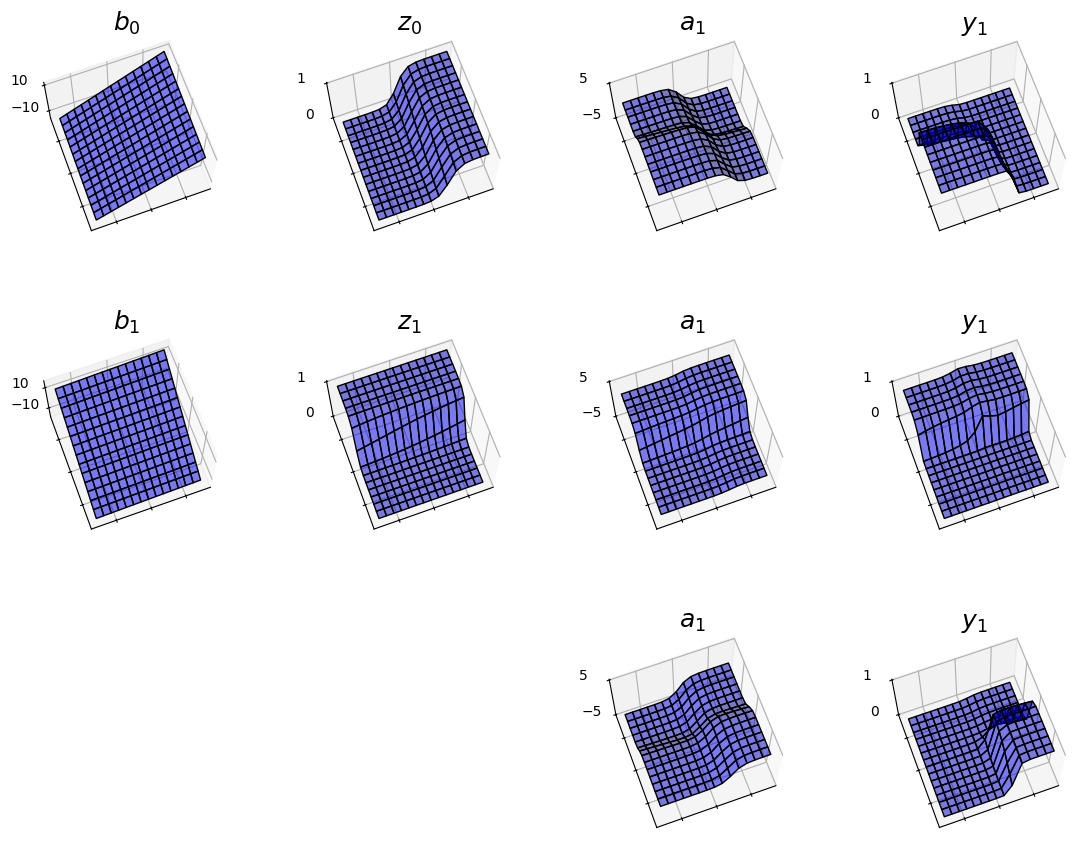

In [14]:
from mpl_toolkits.mplot3d import Axes3D

def show_activation3d(ax, v, v_ticks, title_str):
  f = v.copy()
  f = f.reshape(xn, xn)
  f = f.T
  ax.plot_surface(xx0, xx1, f, color="blue", edgecolor="black", rstride=1, cstride=1, alpha=0.5)
  ax.view_init(70, -110)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_zticks(v_ticks)
  ax.set_title(title_str, fontsize=18)

M = 2
K = 3
xn = 15
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, "F"), np.reshape(xx1, xn * xn, "F")]
y, a, z, b = FNN(WV, M, K, x)

fig = plt.figure(1, figsize=(12, 9))
plt.subplots_adjust(left=0.075, bottom=0.05, right=0.95, top=0.95, wspace=0.4, hspace=0.4)

for m in range(M):
  ax = fig.add_subplot(3, 4, 1 + m * 4, projection="3d")
  show_activation3d(ax, b[:, m], [-10, 10], "$b_{0:d}$".format(m))
  ax = fig.add_subplot(3, 4, 2 + m * 4, projection="3d")
  show_activation3d(ax, z[:, m], [0, 1], "$z_{0:d}$".format(m))

for k in range(K):
  ax = fig.add_subplot(3, 4, 3 + k * 4, projection="3d")
  show_activation3d(ax, a[:, k], [-5, 5], "$a_{0:d}$".format(m))
  ax = fig.add_subplot(3, 4, 4 + k * 4, projection="3d")
  show_activation3d(ax, y[:, k], [0, 1], "$y_{0:d}$".format(m))

plt.show()

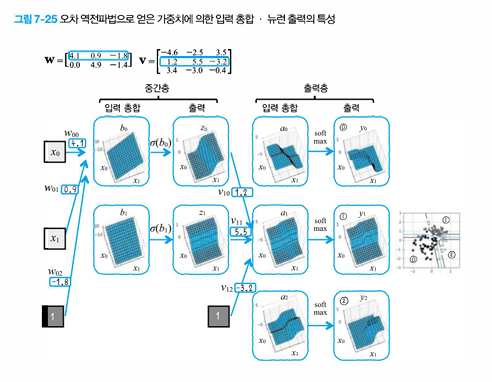

## 7-3 케라스로 신경망 모델 구현

### 2층 피드 포워드 신경망

Keras: TensorFlow, PyTorch 등을 백엔드로 사용하여 비교적 쉬운 API를 제공하는 래퍼 라이브러리

메모리 초기화

In [15]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(1)

import keras.optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation

outfile = np.load("class_data.npz")
X_train = outfile["X_train"]
T_train = outfile["T_train"]
X_test = outfile["X_test"]
T_test = outfile["T_test"]
X_range0 = outfile["X_range0"]
X_range1 = outfile["X_range1"]

In [17]:
def Show_data(x, t):
  wk, n = t.shape
  c = [[0, 0, 0], [0.5, 0.5, 0.5], [1, 1, 1]]
  for i in range(n):
    plt.plot(
      x[t[:, i] == 1, 0],
      x[t[:, i] == 1, 1],
      linestyle="none",
      marker="o",
      markeredgecolor="black",
      color=c[i],
      alpha=0.8
    )
  plt.grid(True)

np.random.seed(1)

model = Sequential()

model.add(Dense(2, input_dim=2, activation="sigmoid", kernel_initializer="uniform"))

model.add(Dense(3, activation="softmax", kernel_initializer="uniform"))

sgd = keras.optimizers.SGD(learning_rate=1.0, momentum=0.0, decay=0.0, nesterov=False)

model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

startTime = time.time()
history = model.fit(X_train, T_train, epochs=1000, batch_size=100, verbose=0, validation_data=(X_test, T_test))

score = model.evaluate(X_test, T_test, verbose=0)
print("cross entropy {0:3.2f}, accuracy: {1:3.2f}".format(score[0], score[1]))
calculation_time = time.time() - startTime
print("Calculation time: {0:.3f} sec".format(calculation_time))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


cross entropy 0.27, accuracy: 0.90
Calculation time: 62.752 sec


학습 과정과 결과 표시

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


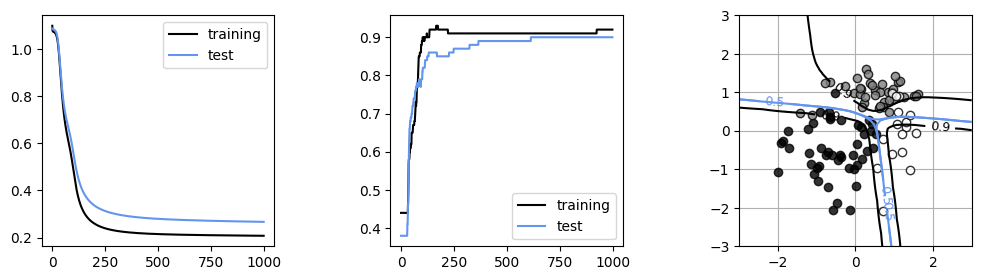

In [18]:
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 3, 1)
plt.plot(history.history["loss"], "black", label="training")
plt.plot(history.history["val_loss"], "cornflowerblue", label="test")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history["accuracy"], "black", label="training")
plt.plot(history.history["val_accuracy"], "cornflowerblue", label="test")
plt.legend()

plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, "F"), np.reshape(xx1, xn * xn, "F")]
y = model.predict(x)
K = 3
for ic in range(K):
  f = y[:, ic]
  f = f.reshape(xn, xn)
  f = f.T
  cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], colors=["cornflowerblue", "black"])
  cont.clabel(fmt="%1.1f", fontsize=9)
  plt.xlim(X_range0)
  plt.ylim(X_range1)

plt.show()

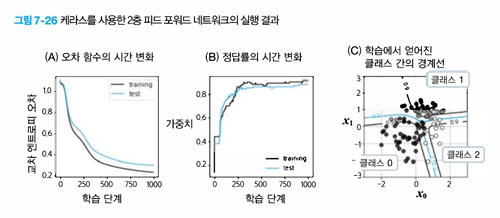